<h1><center>CS 513 Knowledge Discovery and Data Mining</center></h1>
<h1><center>Multiclass Object Classification in Autonomous Driving</center></h1>
<h3>Group Members</h3>
<h4>Bhushan Asati</h4>
<h4>Suyash Madhavi</h4>
<h4>Anirudh Sharma</h4>
<h4>Rujuta Dabke</h4>

Multiclass Object Classification using the KITTI Dataset Models in this script:

- ResNet-50
- EfficientNet80
- MobileNetV2

This script includes:

1) Kaggle API setup and dataset download
2) Data Loading and Preprocessing
3) Training the models
4) Evaluating the models

In [1]:
!pip install -q kaggle
!pip install tensorflow_addons shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time

# Kaggle API Setup and Dataset Download

1. **Upload Kaggle API Key**:
   - The `kaggle.json` file contains your Kaggle credentials.
   - Upload it to Colab using the `files.upload()` method.

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mv ~/.kaggle/kaggle.json /root/.config/kaggle/

mv: cannot move '/root/.kaggle/kaggle.json' to '/root/.config/kaggle/': Not a directory


In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# 2) Data Loading and Preprocessing

1. **Dataset Download**:
   - Download the KITTI dataset using the Kaggle API.
   - Extract the dataset into image and label directories.

2. **Simplifying Categories**:
   - Map original KITTI classes to two categories: `Human` (e.g., Pedestrian, Cyclist) and `Vehicle` (e.g., Car, Truck).
   - Ignore irrelevant classes (`Misc`, `DontCare`).

3. **Image and Label Processing**:
   - Resize images to `224x224`, normalize, and convert to RGB.
   - Map labels to simplified categories.

4. **Data Splitting**:
   - Split data into training, validation, and test sets with balanced class proportions.

5. **Handling Class Imbalance**:
   - Compute class weights to mitigate imbalance during model training.

6. **Data Augmentation**:
   - Apply augmentation (rotation, flipping, zooming) to the training data.

In [5]:
dataset_name = 'garymk/kitti-3d-object-detection-dataset'
dataset_path = '/content/kitti_dataset/'

In [6]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    !kaggle datasets download -d {dataset_name} -p {dataset_path}
    !unzip -q {dataset_path}kitti-3d-object-detection-dataset.zip -d {dataset_path}
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Skipping download.")


Dataset URL: https://www.kaggle.com/datasets/garymk/kitti-3d-object-detection-dataset
License(s): unknown
100% 30.0G/30.0G [04:02<00:00, 251MB/s]
100% 30.0G/30.0G [04:02<00:00, 133MB/s]
Dataset downloaded and extracted successfully.


In [7]:
image_dir = os.path.join(dataset_path, 'training/image_2/')
label_dir = os.path.join(dataset_path, 'training/label_2/')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

In [8]:
# Class Mapping
class_mapping = {
    'Pedestrian': 'Human',
    'Person_sitting': 'Human',
    'Cyclist': 'Human',
    'Car': 'Vehicle',
    'Truck': 'Vehicle',
    'Van': 'Vehicle',
    'Tram': 'Vehicle',
    'Misc': None,       # Exclude Miscellaneous
    'DontCare': None    # Exclude DontCare
}


In [9]:
def map_label(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
        mapped_classes = []
        for line in lines:
            data = line.strip().split()
            obj_class = data[0]
            mapped_class = class_mapping.get(obj_class)
            if mapped_class is not None:
                mapped_classes.append(mapped_class)
        return mapped_classes

TARGET_SIZE = (224, 224)
images = []
labels = []

In [10]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, image_file.replace('.png', '.txt'))
    mapped_classes = map_label(label_path)
    if mapped_classes and len(mapped_classes) > 0:
        # Take the first valid object class found in the image
        label = mapped_classes[0]
        image = cv2.imread(image_path)
        image_resized = cv2.resize(image, TARGET_SIZE)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        images.append(image_rgb)
        labels.append(label)

X = np.array(images)
y = np.array(labels)
X = X / 255.0

In [11]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = list(label_encoder.classes_)
print("Reduced Categories:", class_names)  # Expect: ["Human", "Vehicle"]

Reduced Categories: ['Human', 'Vehicle']


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [13]:
# Calculate class weights
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {}
for class_idx, count in class_counts.items():
    class_weights[class_idx] = total_samples / (len(class_names) * count)

print("Class Weights:", class_weights)

Class Weights: {1: 0.5847665847665847, 0: 3.449275362318841}


# 3) Training the models

1. **Data Augmentation**:
   - Augment training data with rotations, shifts, zooming, and flipping.
   - Normalize validation and test data for evaluation.

2. **Generalized Training Function**:
   - Use `build_and_train_model` to train models like ResNet50, EfficientNetB0, and MobileNetV2.
   - Customize layers for classification and fine-tune the pretrained base model.

3. **Evaluation**:
   - Generate metrics such as accuracy, precision, recall, and F1-score using a classification report.
   - Visualize the confusion matrix and plot training/validation loss and accuracy.


In [14]:
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [16]:
test_datagen = ImageDataGenerator()

In [17]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_gen = test_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)
test_gen = test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)


Training ResNet50...
Epoch 1/10
164/164 [==============================] - 354s 2s/step - loss: 0.2536 - accuracy: 0.9085 - val_loss: 0.4951 - val_accuracy: 0.8556
Epoch 2/10
164/164 [==============================] - 332s 2s/step - loss: 0.1268 - accuracy: 0.9553 - val_loss: 0.3994 - val_accuracy: 0.8556
Epoch 3/10
164/164 [==============================] - 337s 2s/step - loss: 0.0851 - accuracy: 0.9687 - val_loss: 0.7321 - val_accuracy: 0.5152
Epoch 4/10
164/164 [==============================] - 332s 2s/step - loss: 0.0549 - accuracy: 0.9794 - val_loss: 0.8886 - val_accuracy: 0.5134
Epoch 5/10
164/164 [==============================] - 334s 2s/step - loss: 0.0519 - accuracy: 0.9801 - val_loss: 0.7773 - val_accuracy: 0.6176
Epoch 6/10
164/164 [==============================] - 332s 2s/step - loss: 0.0513 - accuracy: 0.9813 - val_loss: 0.7368 - val_accuracy: 0.7389
Epoch 7/10
164/164 [==============================] - 330s 2s/step - loss: 0.0395 - accuracy: 0.9862 - val_loss: 0.2826 

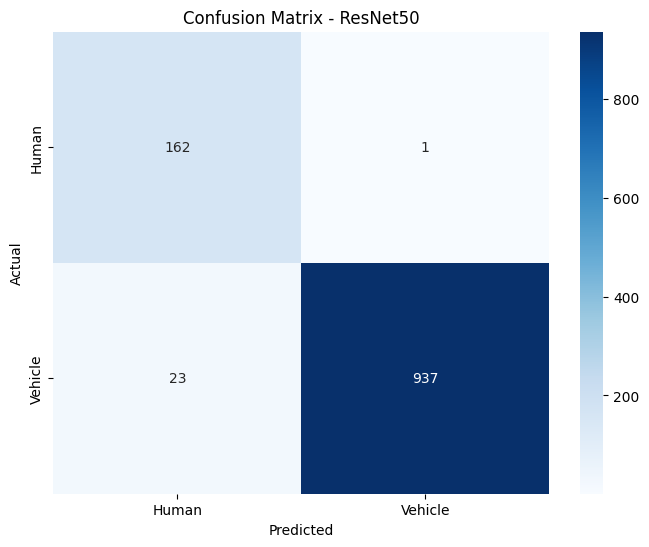

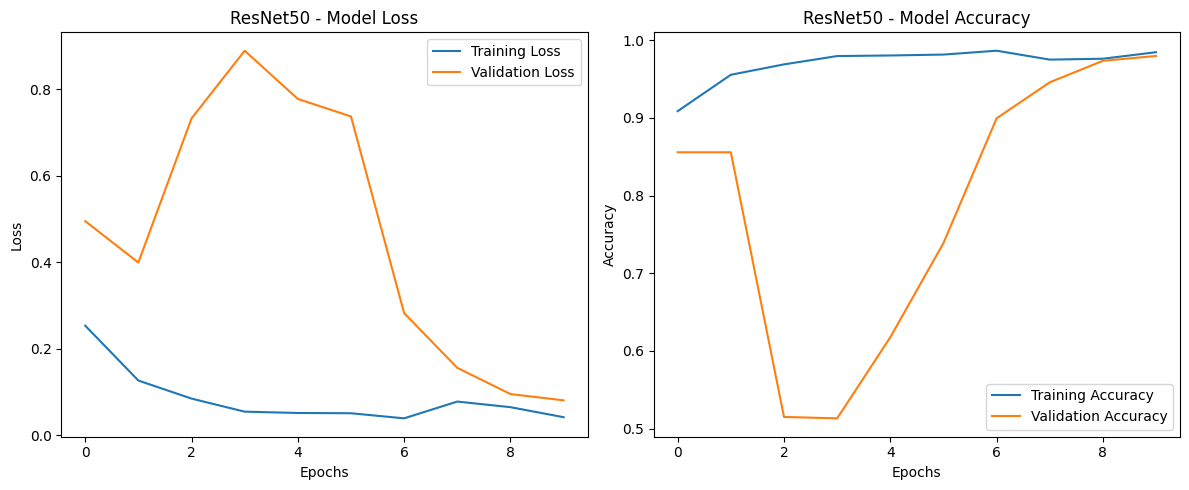

In [20]:
def build_and_train_model(base_model_fn,
                          train_gen, val_gen, test_gen,
                          class_names, class_weights,
                          y_test,  # ensure to pass this
                          input_shape=(224,224,3),
                          learning_rate=1e-4,
                          epochs=10,
                          model_name='model'):

    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nTraining {model_name}...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=class_weights,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_acc*100:.2f}%")

    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    # Use the actual y_test array here
    y_true = y_test

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} - Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} - Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, y_pred, y_pred_probs

# Resnet50
resnet_model, resnet_history, resnet_y_pred, resnet_y_pred_probs = build_and_train_model(
    base_model_fn=ResNet50,
    train_gen=train_gen,
    val_gen=val_gen,
    test_gen=test_gen,
    class_names=class_names,
    class_weights=class_weights,
    y_test=y_test,  # Include y_test here
    input_shape=(224,224,3),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_name='ResNet50'
)


16705208/16705208 [==============================] - 0s 0us/step

Training EfficientNetB0...
Epoch 1/10
164/164 [==============================] - 244s 1s/step - loss: 0.3255 - accuracy: 0.8925 - val_loss: 0.8748 - val_accuracy: 0.1444
Epoch 2/10
164/164 [==============================] - 219s 1s/step - loss: 0.1592 - accuracy: 0.9492 - val_loss: 1.3517 - val_accuracy: 0.1533
Epoch 3/10
164/164 [==============================] - 223s 1s/step - loss: 0.1076 - accuracy: 0.9597 - val_loss: 0.7765 - val_accuracy: 0.5107
Epoch 4/10
164/164 [==============================] - 204s 1s/step - loss: 0.0762 - accuracy: 0.9691 - val_loss: 0.9570 - val_accuracy: 0.4127
Epoch 5/10
164/164 [==============================] - 206s 1s/step - loss: 0.0610 - accuracy: 0.9778 - val_loss: 0.3773 - val_accuracy: 0.8030
Epoch 6/10
164/164 [==============================] - 210s 1s/step - loss: 0.0469 - accuracy: 0.9828 - val_loss: 1.8686 - val_accuracy: 0.1444
Epoch 7/10
164/164 [=============================

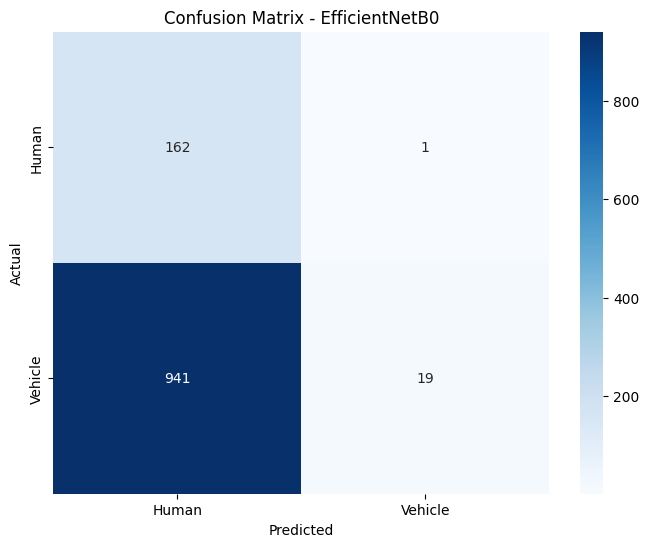

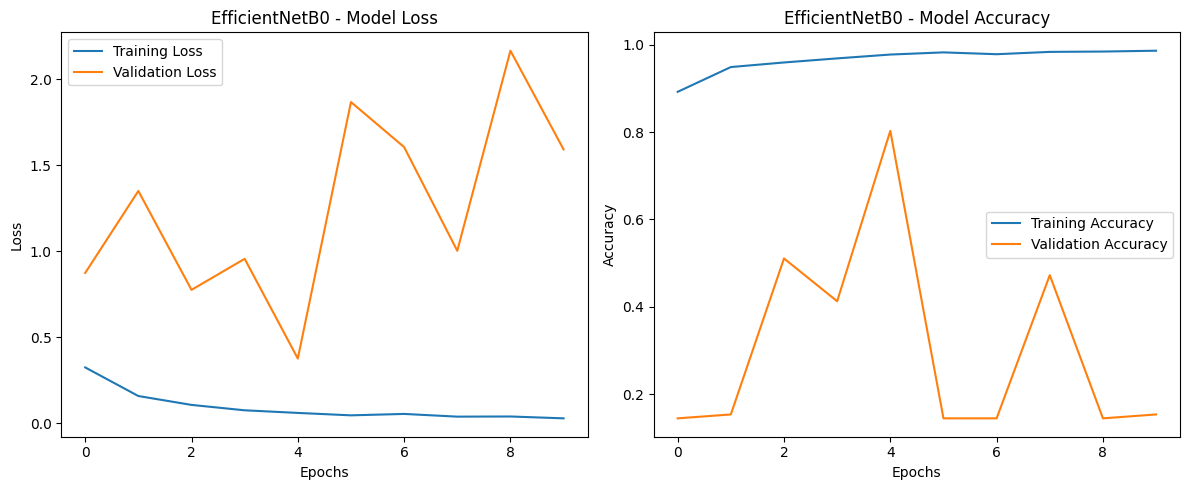

In [22]:
# Model 2: EfficientNetB0
efficientnet_model, efficientnet_history, efficientnet_y_pred, efficientnet_y_pred_probs = build_and_train_model(
    base_model_fn=EfficientNetB0,
    train_gen=train_gen,
    val_gen=val_gen,
    test_gen=test_gen,
    class_names=class_names,
    class_weights=class_weights,
    input_shape=(224,224,3),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_name='EfficientNetB0',
    y_test=y_test  # Include y_test here
)

9406464/9406464 [==============================] - 0s 0us/step

Training MobileNetV2...
Epoch 1/10
164/164 [==============================] - 154s 864ms/step - loss: 0.2760 - accuracy: 0.9051 - val_loss: 0.1717 - val_accuracy: 0.9465
Epoch 2/10
164/164 [==============================] - 146s 889ms/step - loss: 0.1169 - accuracy: 0.9561 - val_loss: 0.1197 - val_accuracy: 0.9563
Epoch 3/10
164/164 [==============================] - 134s 815ms/step - loss: 0.0723 - accuracy: 0.9710 - val_loss: 0.1275 - val_accuracy: 0.9554
Epoch 4/10
164/164 [==============================] - 136s 825ms/step - loss: 0.0671 - accuracy: 0.9714 - val_loss: 0.0891 - val_accuracy: 0.9706
Epoch 5/10
164/164 [==============================] - 136s 826ms/step - loss: 0.0516 - accuracy: 0.9803 - val_loss: 0.1193 - val_accuracy: 0.9545
Epoch 6/10
164/164 [==============================] - 135s 820ms/step - loss: 0.0447 - accuracy: 0.9834 - val_loss: 0.1274 - val_accuracy: 0.9510
Epoch 7/10
164/164 [================

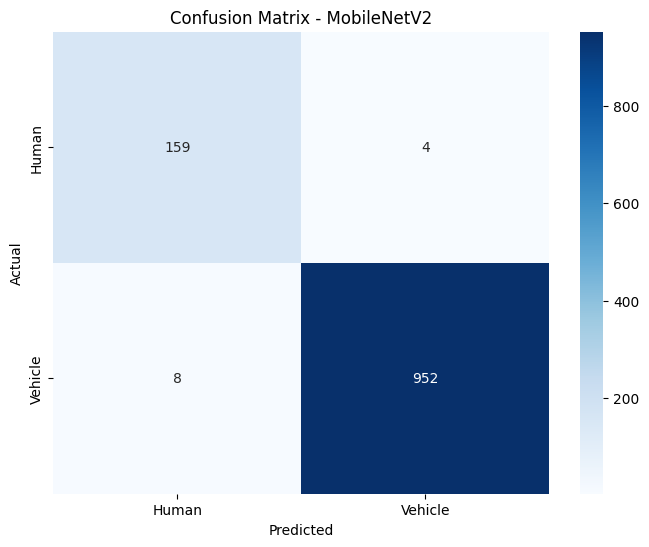

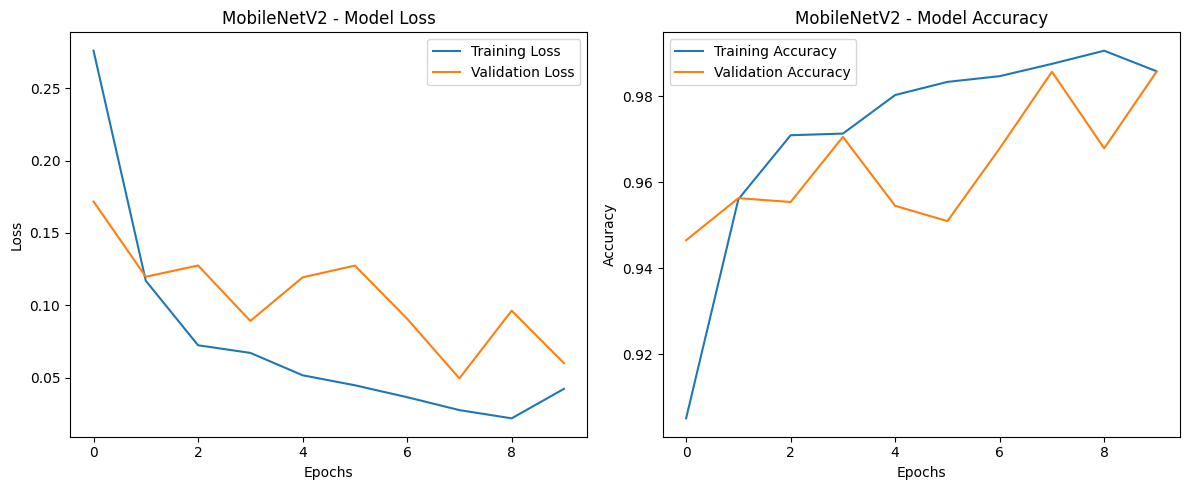

In [24]:
# Model 3: MobileNetV2
mobilenet_model, mobilenet_history, mobilenet_y_pred, mobilenet_y_pred_probs = build_and_train_model(
    base_model_fn=MobileNetV2,
    train_gen=train_gen,
    val_gen=val_gen,
    test_gen=test_gen,
    class_names=class_names,
    class_weights=class_weights,
    y_test=y_test,  # Include y_test here
    input_shape=(224,224,3),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_name='MobileNetV2'
)

# 4) Evaluating and comparing the models

1. **Results**:
   - Easily compare the performance of multiple architectures (ResNet50, EfficientNetB0, MobileNetV2).

2. **Metrics Used**:
   - **Precision**: How many of the predicted positive samples are actually correct.
   - **Recall**: How many of the actual positive samples are correctly identified.
   - **F1-Score**: Harmonic mean of Precision and Recall, providing a balanced measure.

3. **Model Comparison**:
   - Models (ResNet50, EfficientNetB0, MobileNetV2) are evaluated on weighted Precision, Recall, and F1-Score.
   - Weighted averages ensure metrics are not biased due to class imbalance.

4. **Insights**:
   - These metrics help determine the most accurate and balanced model for the given dataset.


In [25]:
# Comparison of Models
models_metrics = {
    "ResNet50": (resnet_y_pred, resnet_y_pred_probs),
    "EfficientNetB0": (efficientnet_y_pred, efficientnet_y_pred_probs),
    "MobileNetV2": (mobilenet_y_pred, mobilenet_y_pred_probs)
}

In [27]:
# Assuming y_test is available in the current scope
for model_name, (y_pred, y_pred_probs) in models_metrics.items():
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{model_name} Performance:")
    print(f"Weighted Precision: {precision*100:.2f}%")
    print(f"Weighted Recall: {recall*100:.2f}%")
    print(f"Weighted F1-Score: {f1*100:.2f}%")

print("\nAll models evaluated.")


ResNet50 Performance:
Weighted Precision: 98.10%
Weighted Recall: 97.86%
Weighted F1-Score: 97.92%

EfficientNetB0 Performance:
Weighted Precision: 83.34%
Weighted Recall: 16.12%
Weighted F1-Score: 7.03%

MobileNetV2 Performance:
Weighted Precision: 98.95%
Weighted Recall: 98.93%
Weighted F1-Score: 98.94%

All models evaluated.
